<h2>Problem Definition</h2>

<h2>Solution Specification</h2>

<h2>Data Importing</h2>

In [292]:
#import libraries
import numpy as np
import pandas as pd
#pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.25)

In [2]:
df = pd.read_json('image-data.json')
df.head(10)

,account_age,artist_asl,artist_comments,artist_critiques,artist_deviations,artist_dob,artist_faves,artist_forum_posts,artist_page_views,artist_scraps,...,comments,date_posted,downloads,faves,hashtags,image_links,image_paths,image_urls,titles,views
0,Deviant for 5 Years,Female/France,468,0.0,183,March 5,"1,830",0,"10,611",0,...,22.0,"January 17, 2014",91.0,142,NaN,https://www.deviantart.com/get-sherlock/art/Sh...,[full/c11741fda71c47368b3ecc42de439de62c48cf30...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,1597
1,Deviant for 7 Years,Female/Moldova,376,0.0,140,June 21,417,0,"23,291",0,...,70.0,"August 26, 2013",NaN,900,NaN,https://www.deviantart.com/nadia-ch/art/Sherlo...,[full/7dd4af05bd4fca98ce1688c899c444e3e6e12c0d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,9546
2,Deviant for 8 Years,Female/Russia,169,0.0,36,March 5,216,0,"11,368",2,...,45.0,"December 30, 2011",186.0,1135,NaN,https://www.deviantart.com/masterhalfling/art/...,[full/09fbbe05751a1b08cf03445e0821ca44dd5b547b...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,14150
3,Deviant for 6 Years,People's Republic of China,97,0.0,66,June 18,"1,133",0,"7,418",0,...,20.0,"August 17, 2012",20.0,258,NaN,https://www.deviantart.com/jaslerb/art/sherloc...,[full/39524abdbf4128e28696adc9c450d6d59887d012...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,sherlock,3389
4,Deviant for 11 Years,Female/Russia,339,0.0,127,February 27,147,0,"49,622",0,...,88.0,"September 7, 2010",193.0,1702,[cumberbatchsherlock],https://www.deviantart.com/umino-aka-morskaya/...,[full/240c5af33c8a67a4e9f69bcad604ab421e85c86c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,25435
5,Deviant for 8 Years,Unknown,759,0.0,62,March 22,482,0,"89,325",0,...,322.0,"October 27, 2010",803.0,5494,NaN,https://www.deviantart.com/madtenka/art/sherlo...,[full/23fa7bc5787bbfc6ef45b1d916d9a22cf2dd5522...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,sherlock,86962
6,Deviant for 7 Years,Unknown,56,0.0,42,NaN,73,0,"15,524",0,...,42.0,"January 30, 2012",283.0,1560,NaN,https://www.deviantart.com/unisha/art/Sherlock...,[full/1e8b904f0bb82d4f5dfca301704d95e6cab4273d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,20889
7,Deviant for 4 Years,Female/People's Republic of China,555,0.0,117,September 27,118,0,"22,392",0,...,27.0,"January 15, 2015",20.0,172,"[digitalart, sherlock, sherlockholmes, bbcsher...",https://www.deviantart.com/pastellzhq/art/Sher...,[full/0661b9a11eefe54a2f0814bdb243fd5e1ea72047...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,1326
8,Deviant for 7 Years,Female/Germany,"6,820",4.0,230,April 5,"3,788",0,"54,934",7,...,58.0,"February 23, 2013",NaN,213,NaN,https://www.deviantart.com/saraais/art/Sherloc...,[full/61ec395c98b4f1c544a5598328ead6fa85ee310c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,2268
9,Deviant for 9 Years,Female/Brazil,64,0.0,9,NaN,169,0,"2,472",0,...,8.0,"February 25, 2012",NaN,200,NaN,https://www.deviantart.com/lanna367/art/Sherlo...,[full/8b7eccebfa53fdf29f5435dc9f4f66e99e1f0f77...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,3034


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406 entries, 0 to 3405
Data columns (total 23 columns):
account_age           3397 non-null object
artist_asl            3397 non-null object
artist_comments       3397 non-null object
artist_critiques      3397 non-null float64
artist_deviations     3397 non-null object
artist_dob            2678 non-null object
artist_faves          3397 non-null object
artist_forum_posts    3397 non-null object
artist_page_views     3397 non-null object
artist_scraps         3397 non-null object
artist_urls           3397 non-null object
artist_watchers       3397 non-null object
artists               3406 non-null object
comments              3402 non-null float64
date_posted           3406 non-null object
downloads             2493 non-null float64
faves                 3406 non-null int64
hashtags              408 non-null object
image_links           3406 non-null object
image_paths           3406 non-null object
image_urls            3406 non-n

In [ ]:
#Data explanation and observations
#insert table explaning the data columns and justifying their missing values

<h2>Data Cleaning and Preprocessing</h2>

The dataframe info reveals that some of the columns are not in the right format, and there are also some missing values. Most - if not all - of the missing values can be rationally explained, as shown in the table above. While I would ideally have cleaned all the columns, some of the columns required non-trivial cleaning methods, and so I omitted cleaning them due to time constraints. Given additional time and resources, I believe that the "ignored" columns should be cleaned as they could provide significant input power to the model, bearing in mind that those with a significant number of missing values may skew the model if an appropriate filtering method is not chosen.

The following section details the cleaning process of all the "included" columns, and the section below this lists the "ignored" columns as well as brief explanations as to why their cleaning process would be non-trivial. In some cases, the portion of non-null objects is too small to justify cleaning the column, e.g. <b>hashtags</b> only has 408 data points out of 3406 within the entire dataset.

<h3>Included Columns</h3>

Included columns are columns that were <b>included in the cleaning process.</b> This means that the columns fit the following criteria:

a) need to be cleaned due to improper format; 

b) have strong justification for being cleaned (sufficient data points, cleaning process does not take too long, etc.). 

Do note that columns which need not be cleaned may still be included in the final dataframe to be analyzed, even if they are not listed below.

<b>Included columns:</b>

- account_age           
- artist_comments            
- artist_deviations     
- artist_faves          
- artist_forum_posts    
- artist_page_views     
- artist_scraps                 
- artist_watchers                   
- date_posted                        

In [4]:
#cleaning account_age column
print("Original calue counts in account_age column")
print(df['account_age'].value_counts(dropna=False))

#use test_df first since cleaning process is a bit tricky - avoid overwriting original df
test_df = pd.DataFrame() 

test_df['aa'] = df['account_age'].replace(r'^\s*$', np.nan, regex=True) #replace empty spaces with nan
test_df['value'] = test_df['aa'].str.extract('(\d+)').astype(float) #time value
test_df['time_unit'] = test_df['aa'].str[-6:] #time unit
test_df['time_unit'] = test_df['time_unit'].str.strip() #strip time unit of any blank spaces

#if time unit is months, convert value to month time delta, else convert to year time delta
test_df['value'] = np.where(test_df['time_unit']=='Months', 
                            pd.to_timedelta(test_df['value'], unit='M'),
                             pd.to_timedelta(test_df['value'], unit='Y'))

print()
print("Cleaned value counts")
print(test_df['value'].value_counts(dropna=False).sort_values(ascending=False))

#lastly, assign cleaned column back to original df
df['account_age'] = test_df['value']

Original calue counts in account_age column
Deviant for 7  Years      523
Deviant for 8  Years      518
Deviant for 9  Years      422
Deviant for 10  Years     368
Deviant for 11  Years     351
Deviant for 6  Years      270
Deviant for 12  Years     259
Deviant for 13  Years     159
Deviant for 5  Years      148
Deviant for 14  Years     121
Deviant for 15  Years     105
Deviant for 4  Years       61
Deviant for 3  Years       30
Deviant for 16  Years      29
Deviant for 2  Years       24
NaN                         9
Deviant for 1  Year         4
Deviant for 17  Years       2
Deviant for 18  Years       1
Deviant for 7  Months       1
Deviant for 10  Months      1
Name: account_age, dtype: int64

Cleaned value counts
2556 days 16:44:24    523
2921 days 22:33:36    518
3287 days 04:22:48    422
3652 days 10:12:00    368
4017 days 16:01:12    351
2191 days 10:55:12    270
4382 days 21:50:24    259
4748 days 03:39:36    159
1826 days 05:06:00    148
5113 days 09:28:48    121
5478 days 15

In [5]:
#cleaning artist attributes - done in bulk because trivial
df['artist_comments'] = df['artist_comments'].str.replace(',', '').astype(float)
df['artist_deviations'] = df['artist_deviations'].str.replace(',', '').astype(float)
df['artist_faves'] = df['artist_faves'].str.replace(',', '').astype(float)
df['artist_forum_posts'] = df['artist_forum_posts'].str.replace(',', '').astype(float)
df['artist_page_views'] = df['artist_page_views'].str.replace(',', '').astype(float)
df['artist_scraps'] = df['artist_scraps'].str.replace(',', '').astype(float)
df['artist_watchers'] = df['artist_watchers'].str.replace(',', '').astype(float)


In [6]:
#cleaning date_posted column
#convert dates to datetime
#a few dates don't have years, which makes their "age" quite meaningless. The errors are coerced so produce NaN outputs,
#which will later be removed from the dataset.
test_df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce') 


#get number of days between image post date and oldest post date in dataset
test_df['image_age'] = (test_df['date_posted'] - test_df['date_posted'].min()).dt.days
print(f"Number of Nans: {sum(test_df['image_age'].isna())}")

#assign image_age and date_posted column to actual df
df['image_age'] = test_df['image_age']
df['date_posted'] = test_df['date_posted']

Number of Nans: 6


<h3>Ignored columns</h3>

Ignored columns are columns that were omitted from the cleaning process despite needing to be cleaned, usually because the cleaning process is too time-consuming (or beyond my skill-level), or the column has too few data points. There are some columns that will be ultimately ignored in the final process, but are not listed here since the data was in the right format (aka they do not need to be cleaned).

<h4>'artist_asl'</h4> 

Data type: List of the age, gender, and country of the artist. 

This is a non-trivial cleaning process since artists may choose to list none to all of the categories listed above, and so trying to parse the list order and assign elements to the proper categories of age, gender, and country can get confusing. Some of the values are also 'Unknown'.

<h4>'artist_dob'</h4>

Data type: A string of the artist's date of birth.

The column was ignored for two reasons. First, there are only 2678 non-null entries. Second, a good amount of entries do not contain a year within the birthdate, which one would assume to have the most potential significant influence.

<h4>'hashtags'</h4>

Data type: List of hashtags posted with the image entry.

The column has only 408 non-null entries, and so was rejected. That being said, it would be interesting in the future to use natural language processing techniques to identify patterns in hashtags within a particular fandom.

In [7]:
#ignored columns and their data formats
df[['artist_asl','artist_dob','hashtags']].head(10)


,artist_asl,artist_dob,hashtags
0,Female/France,March 5,NaN
1,Female/Moldova,June 21,NaN
2,Female/Russia,March 5,NaN
3,People's Republic of China,June 18,NaN
4,Female/Russia,February 27,[cumberbatchsherlock]
5,Unknown,March 22,NaN
6,Unknown,NaN,NaN
7,Female/People's Republic of China,September 27,"[digitalart, sherlock, sherlockholmes, bbcsher..."
8,Female/Germany,April 5,NaN
9,Female/Brazil,NaN,NaN


<h3>Final Dataframe</h3>

In the final iteration of dataframe cleaning, the 'Ignored' columns were removed. The 'downloads' was also removed since it only has 2493 non-null data points. 

'faves' is intended as the predicted variable. Although some of the columns such as 'comments' and 'views' can't fairly be used in the predictive process (since one does not know the number of views and comments of an image beforehand), they are still retained for analysis of their distributions and correlations.

In [149]:
#final df
final_df = df[['account_age','artist_comments','artist_critiques','artist_deviations','artist_faves',
              'artist_forum_posts', 'artist_page_views', 'artist_scraps', 'artist_watchers', 'artists',
              'comments', 'faves', 'titles', 'views', 'date_posted','image_age',
              'image_links','image_paths','image_urls','artist_urls']]
final_df.head(10)

,account_age,artist_comments,artist_critiques,artist_deviations,artist_faves,artist_forum_posts,artist_page_views,artist_scraps,artist_watchers,artists,comments,faves,titles,views,date_posted,image_age,image_links,image_paths,image_urls,artist_urls
0,1826 days 05:06:00,468.0,0.0,183.0,1830.0,0.0,10611.0,0.0,54.0,get-sherlock,22.0,142,Sherlock,1597,2014-01-17,3925.0,https://www.deviantart.com/get-sherlock/art/Sh...,[full/c11741fda71c47368b3ecc42de439de62c48cf30...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/get-sherlock
1,2556 days 16:44:24,376.0,0.0,140.0,417.0,0.0,23291.0,0.0,487.0,Nadia-Ch,70.0,900,Sherlock,9546,2013-08-26,3781.0,https://www.deviantart.com/nadia-ch/art/Sherlo...,[full/7dd4af05bd4fca98ce1688c899c444e3e6e12c0d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/nadia-ch
2,2921 days 22:33:36,169.0,0.0,36.0,216.0,0.0,11368.0,2.0,135.0,masterHalfling,45.0,1135,Sherlock,14150,2011-12-30,3176.0,https://www.deviantart.com/masterhalfling/art/...,[full/09fbbe05751a1b08cf03445e0821ca44dd5b547b...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/masterhalfling
3,2191 days 10:55:12,97.0,0.0,66.0,1133.0,0.0,7418.0,0.0,25.0,jaslerb,20.0,258,sherlock,3389,2012-08-17,3407.0,https://www.deviantart.com/jaslerb/art/sherloc...,[full/39524abdbf4128e28696adc9c450d6d59887d012...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/jaslerb
4,4017 days 16:01:12,339.0,0.0,127.0,147.0,0.0,49622.0,0.0,489.0,Umino-aka-Morskaya,88.0,1702,Sherlock,25435,2010-09-07,2697.0,https://www.deviantart.com/umino-aka-morskaya/...,[full/240c5af33c8a67a4e9f69bcad604ab421e85c86c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/umino-aka-morskaya
5,2921 days 22:33:36,759.0,0.0,62.0,482.0,0.0,89325.0,0.0,2941.0,madtenka,322.0,5494,sherlock,86962,2010-10-27,2747.0,https://www.deviantart.com/madtenka/art/sherlo...,[full/23fa7bc5787bbfc6ef45b1d916d9a22cf2dd5522...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/madtenka
6,2556 days 16:44:24,56.0,0.0,42.0,73.0,0.0,15524.0,0.0,432.0,Unisha,42.0,1560,Sherlock,20889,2012-01-30,3207.0,https://www.deviantart.com/unisha/art/Sherlock...,[full/1e8b904f0bb82d4f5dfca301704d95e6cab4273d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/unisha
7,1460 days 23:16:48,555.0,0.0,117.0,118.0,0.0,22392.0,0.0,624.0,pastellZHQ,27.0,172,Sherlock,1326,2015-01-15,4288.0,https://www.deviantart.com/pastellzhq/art/Sher...,[full/0661b9a11eefe54a2f0814bdb243fd5e1ea72047...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/pastellzhq
8,2556 days 16:44:24,6820.0,4.0,230.0,3788.0,0.0,54934.0,7.0,1906.0,Saraais,58.0,213,Sherlock,2268,2013-02-23,3597.0,https://www.deviantart.com/saraais/art/Sherloc...,[full/61ec395c98b4f1c544a5598328ead6fa85ee310c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/saraais
9,3287 days 04:22:48,64.0,0.0,9.0,169.0,0.0,2472.0,0.0,13.0,Lanna367,8.0,200,Sherlock,3034,2012-02-25,3233.0,https://www.deviantart.com/lanna367/art/Sherlo...,[full/8b7eccebfa53fdf29f5435dc9f4f66e99e1f0f77...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,https://www.deviantart.com/lanna367


In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406 entries, 0 to 3405
Data columns (total 16 columns):
account_age           3397 non-null timedelta64[ns]
artist_comments       3397 non-null float64
artist_critiques      3397 non-null float64
artist_deviations     3397 non-null float64
artist_faves          3397 non-null float64
artist_forum_posts    3397 non-null float64
artist_page_views     3397 non-null float64
artist_scraps         3397 non-null float64
artist_watchers       3397 non-null float64
artists               3406 non-null object
comments              3402 non-null float64
faves                 3406 non-null int64
titles                3406 non-null object
views                 3406 non-null int64
date_posted           3400 non-null datetime64[ns]
image_age             3400 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(2), object(2), timedelta64[ns](1)
memory usage: 425.8+ KB


In [259]:
print(f"Number of Nans in DataFrame:\n{final_df.isna().sum()}")

#fill all NaN values with the column's mean amount
final_df = final_df.fillna(final_df.mean())

Number of Nans in DataFrame:
account_age           0
artist_comments       0
artist_critiques      0
artist_deviations     0
artist_faves          0
artist_forum_posts    0
artist_page_views     0
artist_scraps         0
artist_watchers       0
artists               0
comments              0
faves                 0
titles                0
views                 0
date_posted           6
image_age             0
image_links           0
image_paths           0
image_urls            0
artist_urls           9
month_posted          0
year_posted           0
month_year_posted     6
dtype: int64


<h2>Data Analysis</h2>

Now that all the data is cleaned - with only 6 NaN values in the 'date_posted' column (the mean can't be applied since there can't be a "mean" date, furthermore 'date_posted' will not be used in the regression analysis so the 6 NaNs can be safely left in) -  the following analyses wil be conducted to get a better understanding of the data that is being handled:

- Analyzing descriptive statistics (mean, max, mode, unique values, etc.)


- Analyzing the distributions and correlations in the data (using a pairplot)


- Analyzing any variables which contain a time-series component. In this case, only date_posted has a time-series component.

<h3>Descriptive Statistics</h3>

From the descriptive statistics tables below, we see that 

 -lots of zeros in critiques, forum posts, and scraps - most deviantart users don't engage with those activities much.
 -unique title and artists...wanted to use length or something but decided that it probably won't have significant impact

In [37]:
final_df.describe().round(2)

,account_age,artist_comments,artist_critiques,artist_deviations,artist_faves,artist_forum_posts,artist_page_views,artist_scraps,artist_watchers,comments,faves,views,image_age
count,3406,3406.00,3406.00,3406.00,3406.00,3406.00,3406.00,3406.00,3406.00,3406.00,3406.00,3406.00,3406.00
mean,3317 days 02:49:22.284957,4910.46,0.28,313.39,3982.13,48.36,128459.05,19.60,1879.91,27.46,177.84,4079.89,3507.43
std,1021 days 15:41:46.537499,10072.32,1.69,740.85,21459.65,325.40,914079.93,92.98,11867.41,63.94,506.82,8911.88,647.58
min,213 days 01:23:42,0.00,0.00,1.00,0.00,0.00,345.00,0.00,0.00,0.00,8.00,48.00,0.00
25%,2556 days 16:44:24,425.25,0.00,73.00,230.25,0.00,12399.25,0.00,68.00,6.00,42.25,835.00,3194.00
50%,3287 days 04:22:48,1560.00,0.00,169.00,870.50,0.00,28330.50,1.00,250.50,14.00,69.00,1732.50,3381.00
75%,4017 days 16:01:12,4981.75,0.00,348.00,2844.50,2.00,72051.00,11.00,995.75,28.00,140.00,3827.50,3910.00
max,6574 days 08:45:36,189152.00,38.00,34267.00,904920.00,7017.00,44554939.00,3910.00,555551.00,1867.00,13068.00,165264.00,5733.00


In [38]:
final_df.describe(include=['O'])

,artists,titles
count,3406,3406
unique,3398,2220
top,Banned,Sherlock
freq,9,552


<h3>Distributions and Correlations</h3>

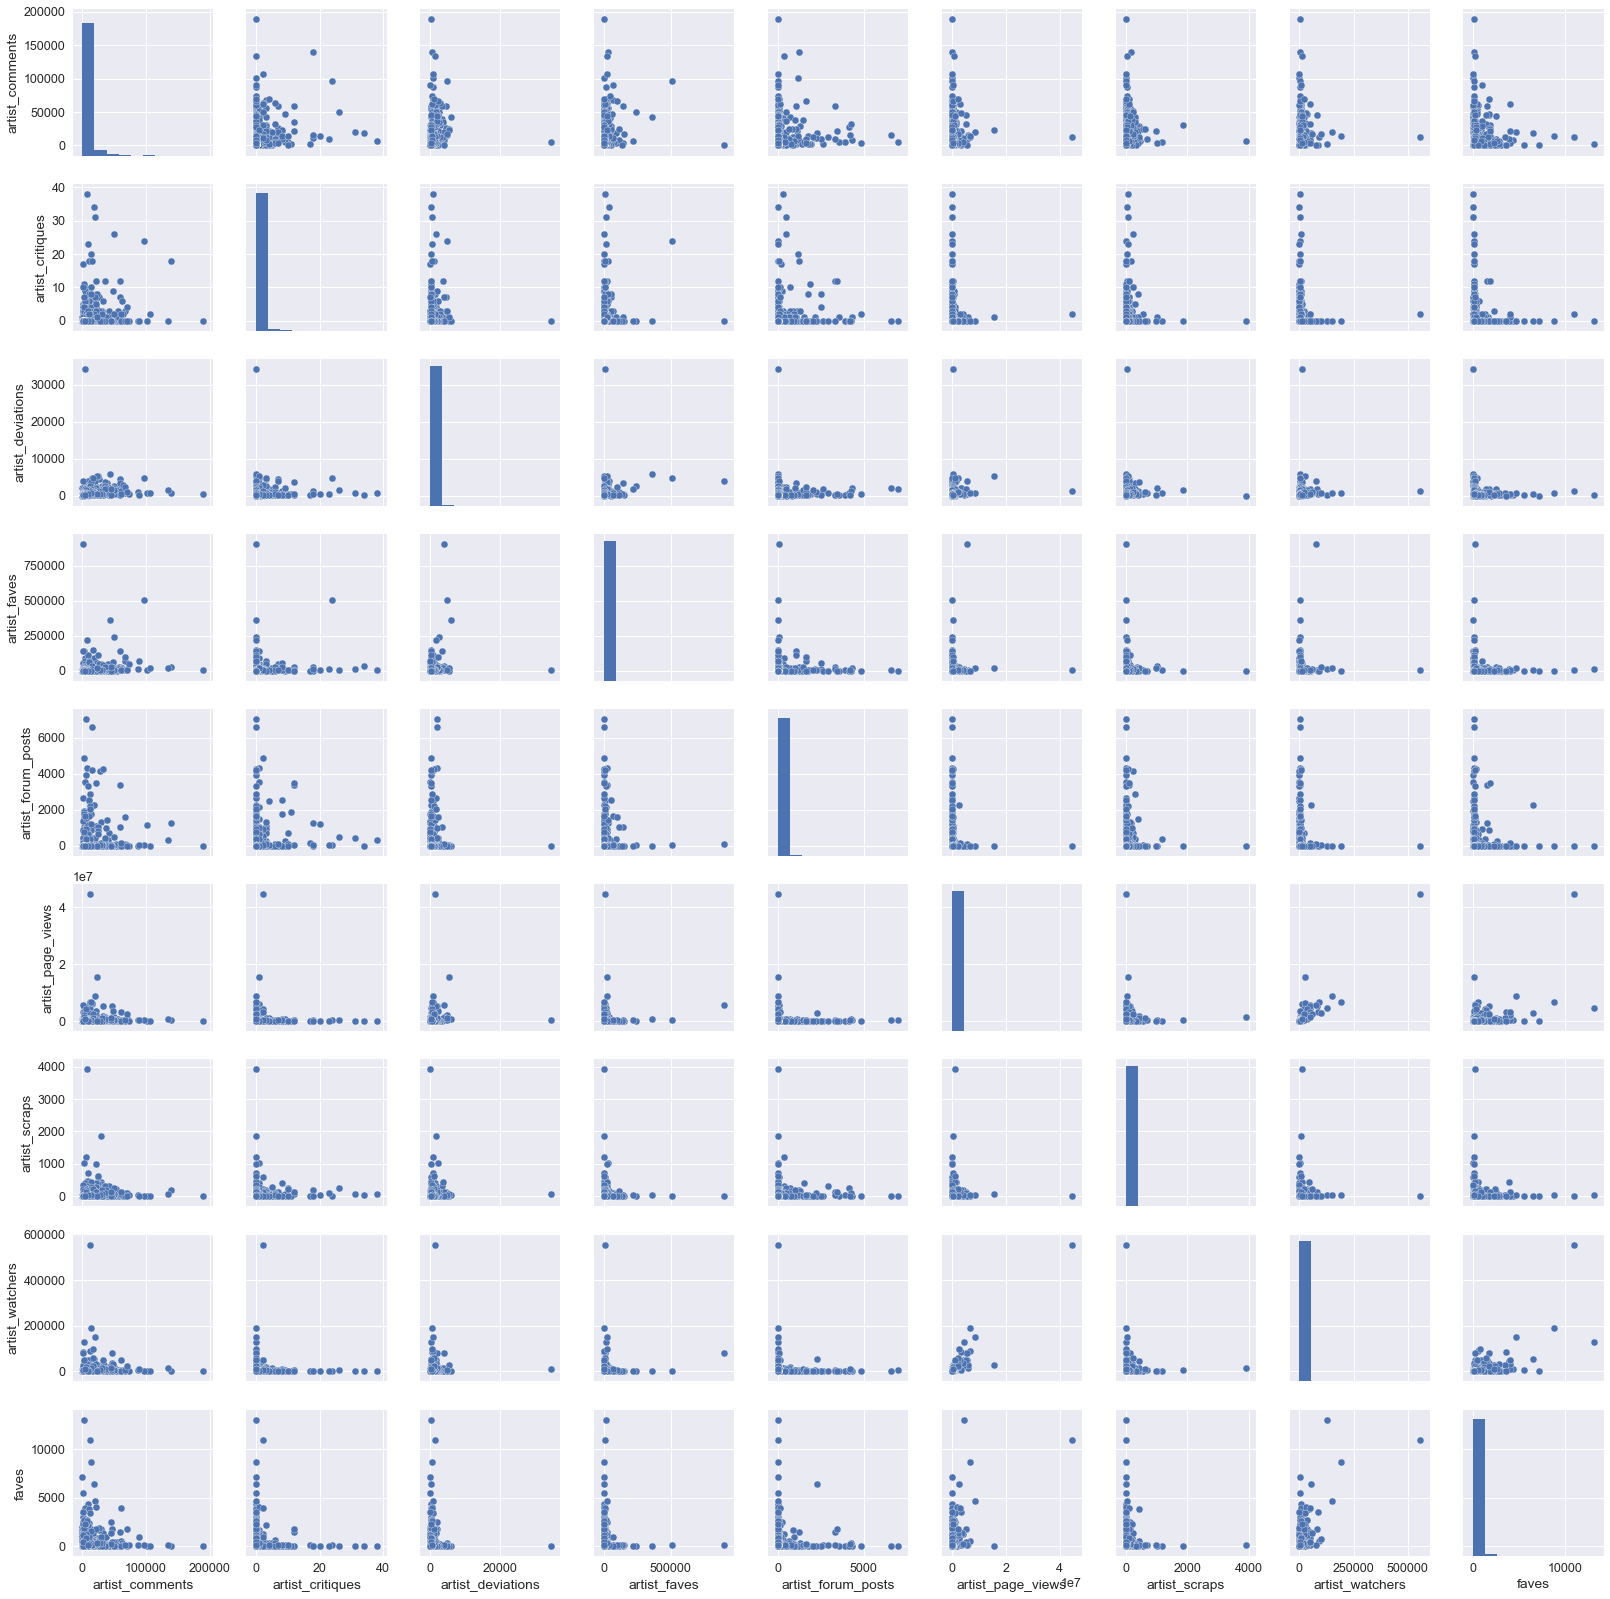

In [293]:
#predictors are features that the artist knows before posting an image (faves is also included as the response variable)
predictors = ['artist_comments','artist_critiques','artist_deviations','artist_faves','artist_forum_posts',
            'artist_page_views','artist_scraps','artist_watchers','faves']

sns.pairplot(final_df[predictors])

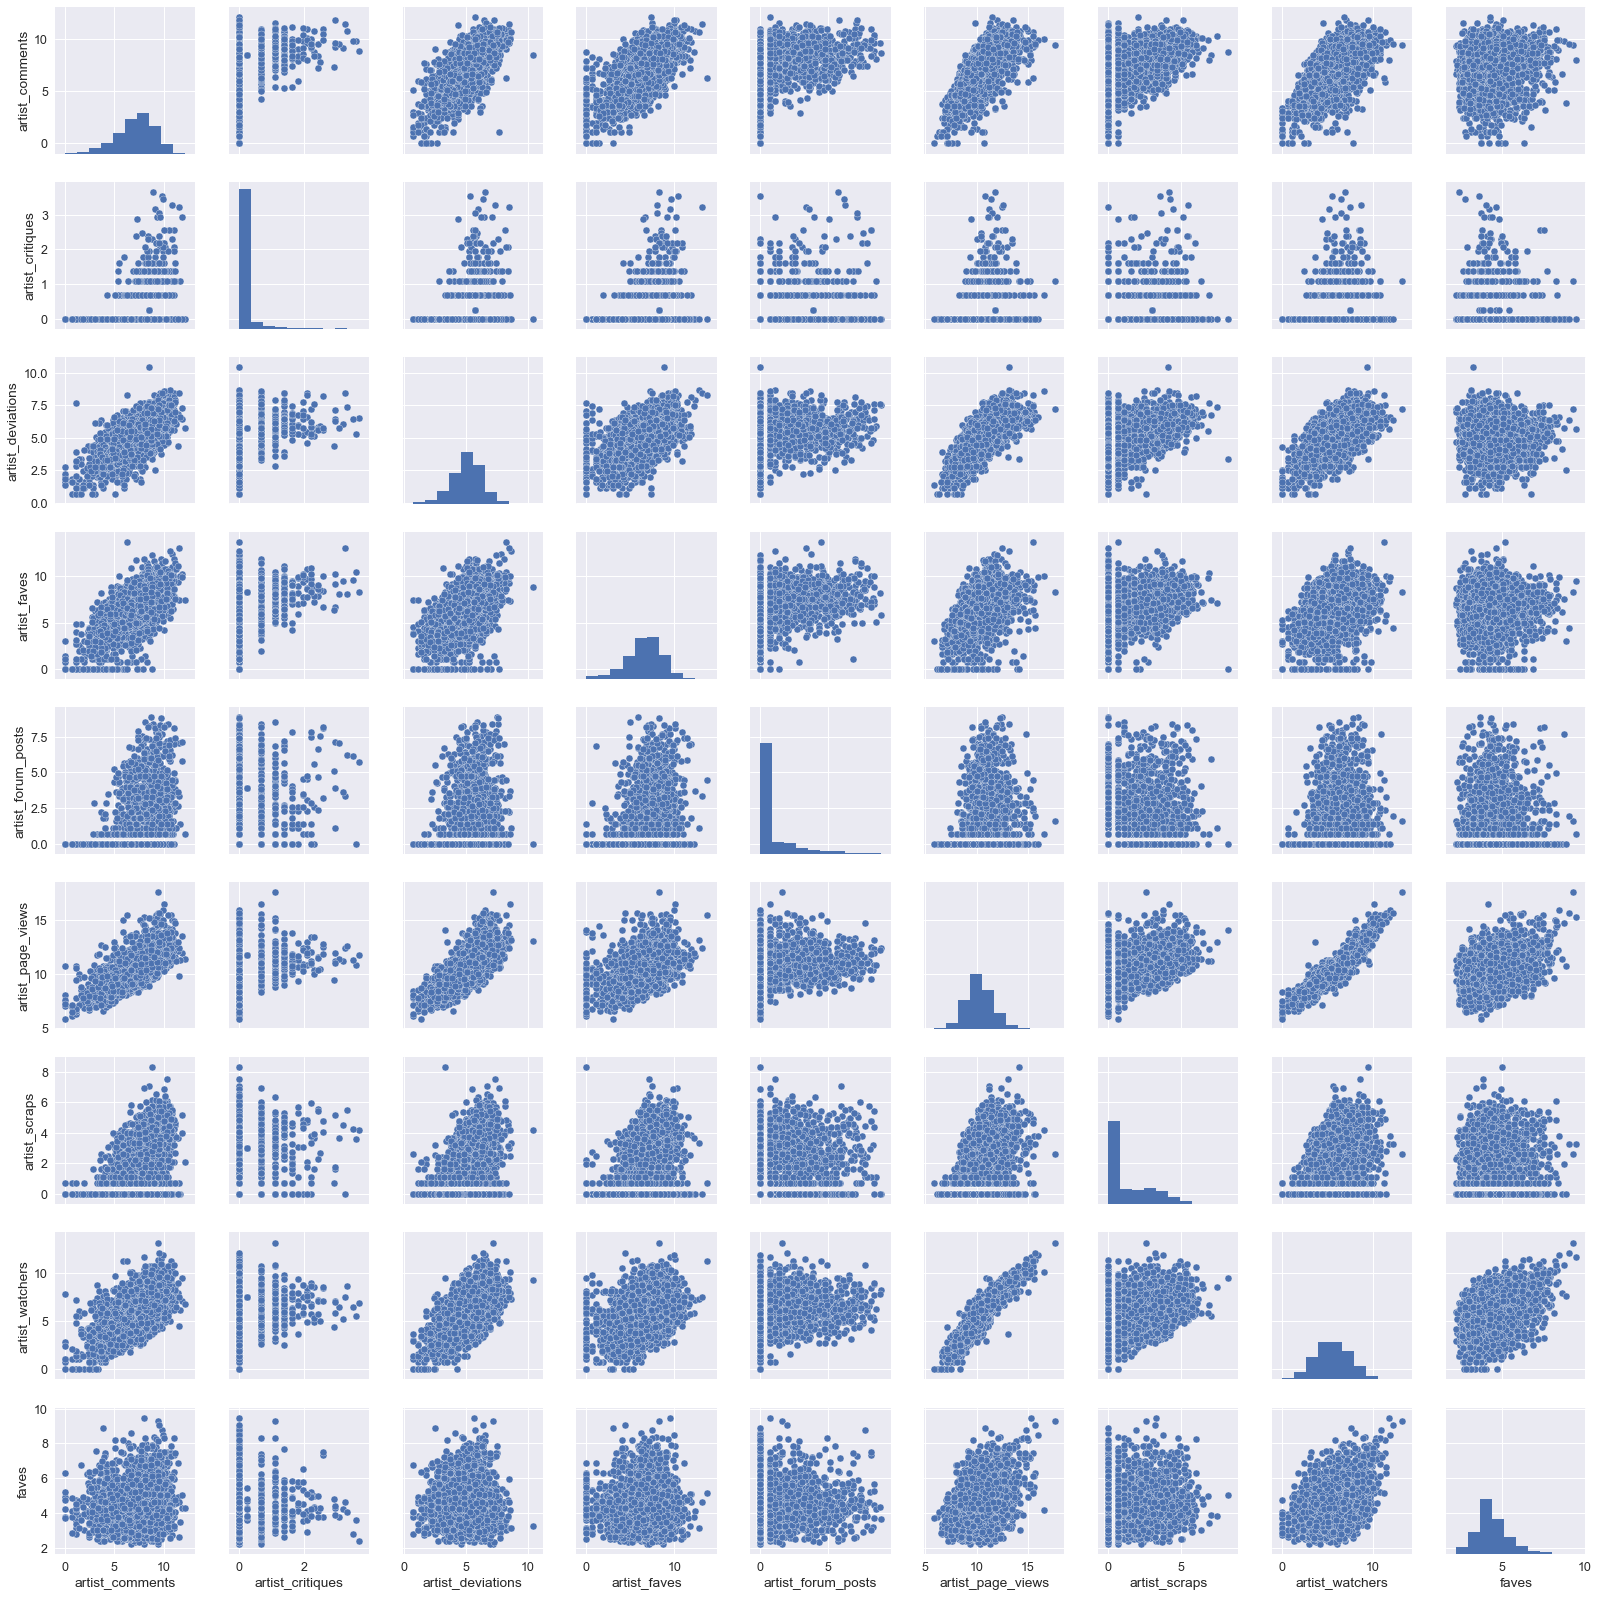

In [294]:
log_predictors_df = np.log(final_df[predictors] + 1)

sns.pairplot(log_predictors_df)


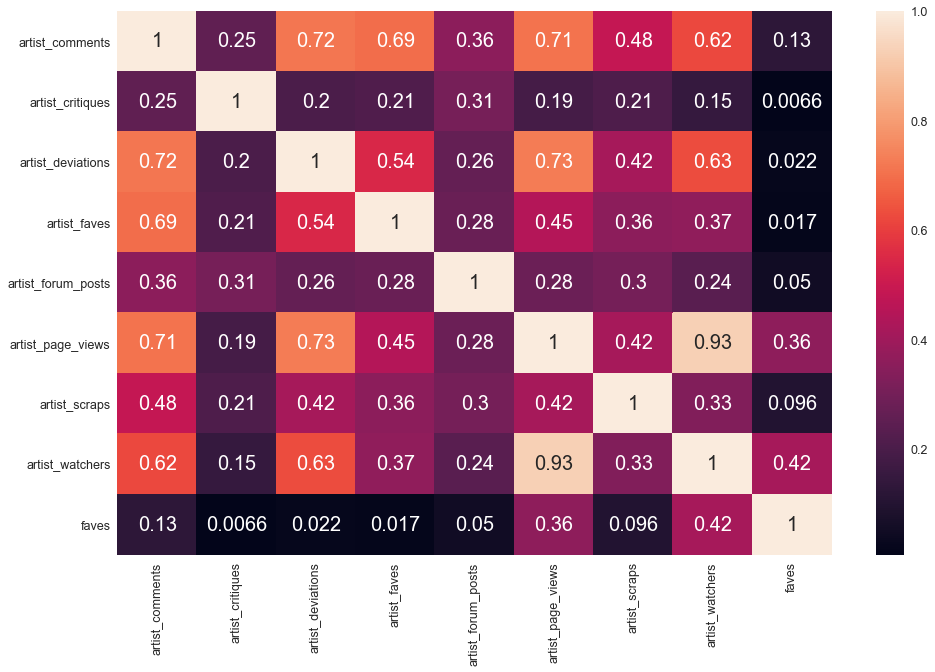

In [295]:
corr = log_predictors_df.corr()
plt.figure(figsize = (16,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, annot_kws={"size": 20})

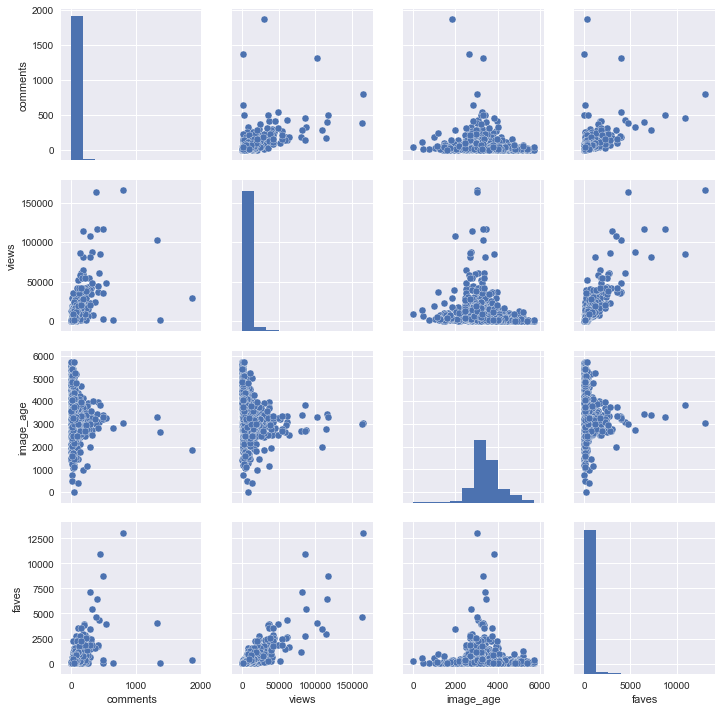

In [269]:
#these other features are only known after posting
others = ['comments','views','image_age','faves']
sns.pairplot(final_df[others])

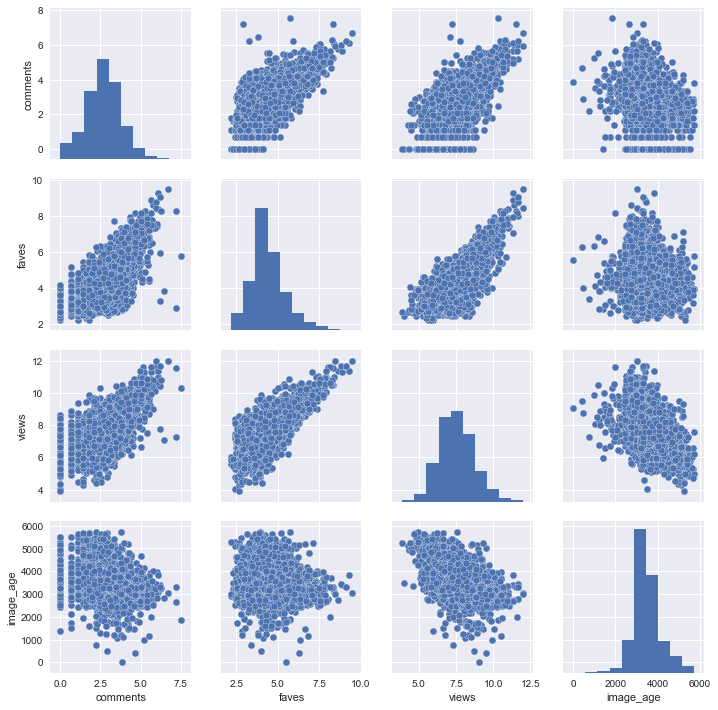

In [270]:
log_others_df = np.log(final_df[['comments','faves','views']] + 1)
log_others_df = pd.concat([log_others_df, final_df['image_age']], axis = 1)
sns.pairplot(log_others_df)

<h3>Time-series of Date Posted</h3>

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Text(0,0.5,'Average number of posts')

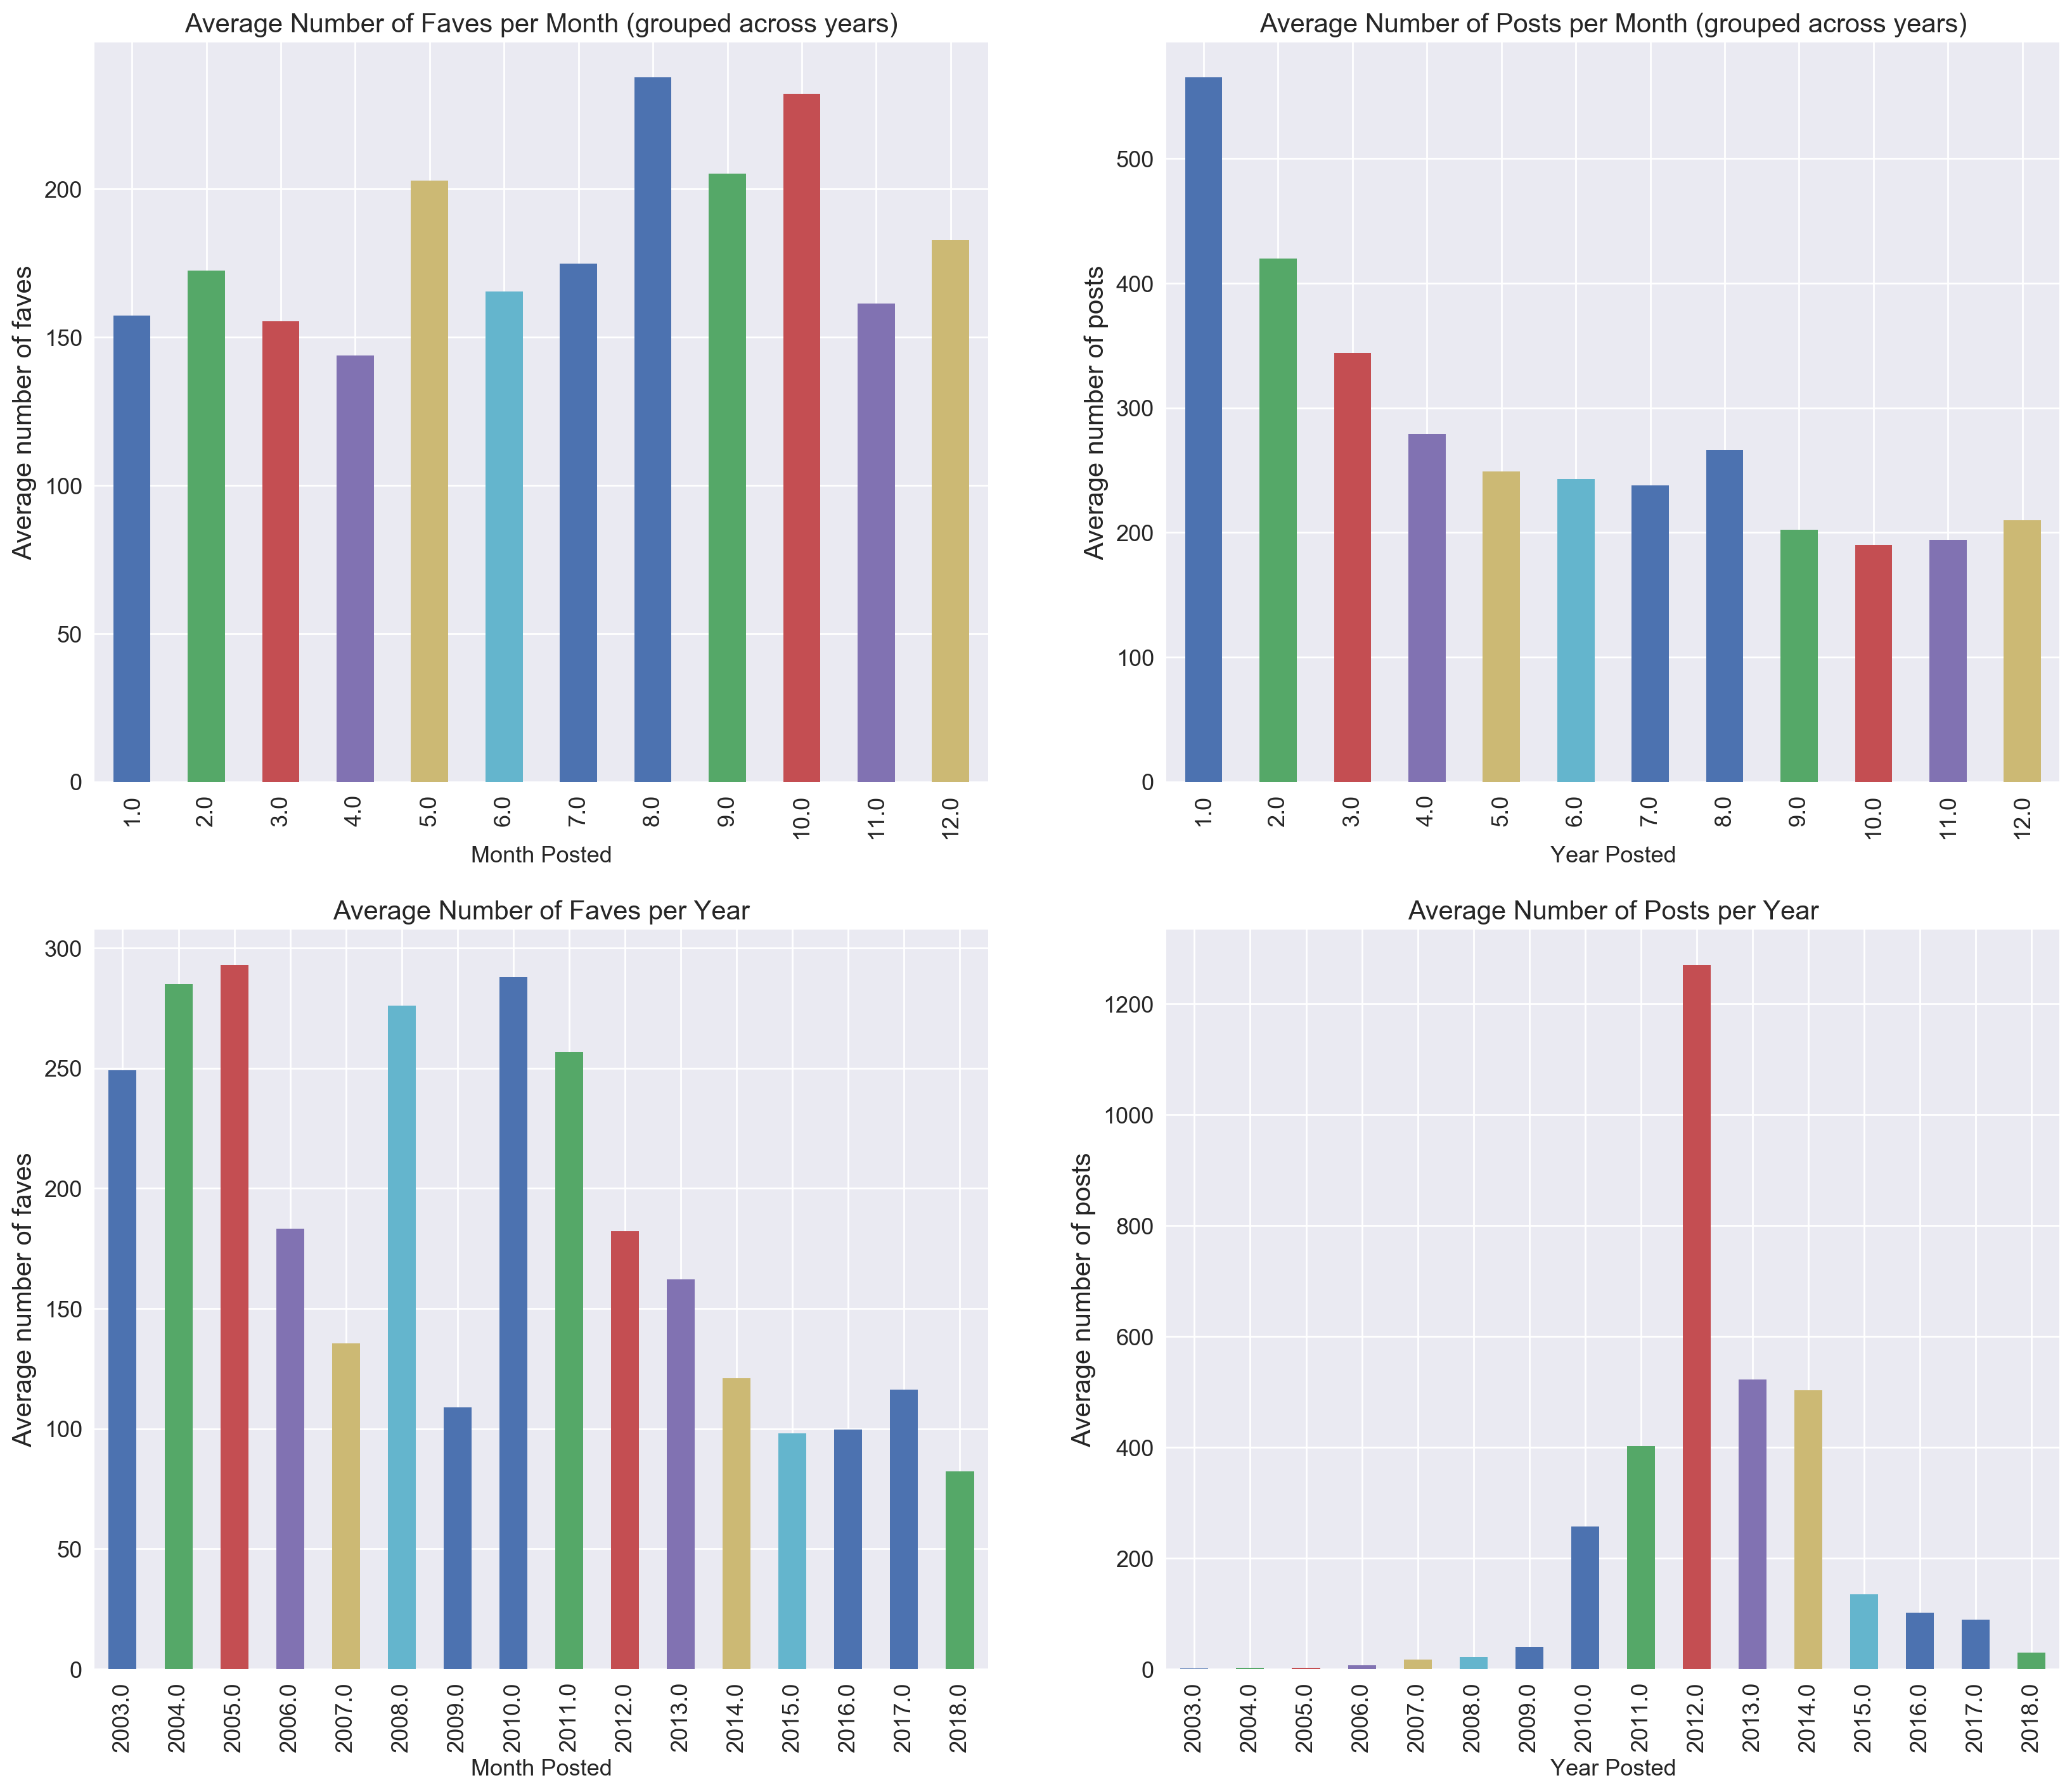

In [195]:
#create month-year column to get monthly time periods
final_df['month_posted'] = final_df['date_posted'].dt.month
final_df['year_posted'] = final_df['date_posted'].dt.year
final_df['month_year_posted'] = final_df['date_posted'].dt.to_period('M')

#get average number of faves based on month and year
monthly_avg_faves = final_df.groupby(final_df['month_posted']).mean()
monthly_posts = final_df.groupby(final_df['month_posted']).count()

yearly_avg_faves = final_df.groupby(final_df['year_posted']).mean()
yearly_posts = final_df.groupby(final_df['year_posted']).count()

month_year_avg_faves = final_df.groupby(final_df['month_year_posted']).mean()
month_year_posts = final_df.groupby(final_df['month_year_posted']).count()

#barplot of average number of faves per month
plt.figure(figsize=(20,17), dpi=200)
plt.subplot(221)
monthly_avg_faves['faves'].plot(kind='bar',fontsize=13)
plt.title("Average Number of Faves per Month (grouped across years)", fontsize=15)
plt.xlabel("Month Posted", fontsize=13)
plt.ylabel("Average number of faves", fontsize=15)

plt.subplot(222)
monthly_posts['faves'].plot(kind='bar',fontsize=13)
plt.title("Average Number of Posts per Month (grouped across years)", fontsize=15)
plt.xlabel("Year Posted", fontsize=13)
plt.ylabel("Average number of posts", fontsize=15)

plt.subplot(223)
yearly_avg_faves['faves'].plot(kind='bar',fontsize=13)
plt.title("Average Number of Faves per Year", fontsize=15)
plt.xlabel("Month Posted", fontsize=13)
plt.ylabel("Average number of faves", fontsize=15)

plt.subplot(224)
yearly_posts['faves'].plot(kind='bar',fontsize=13)
plt.title("Average Number of Posts per Year", fontsize=15)
plt.xlabel("Year Posted", fontsize=13)
plt.ylabel("Average number of posts", fontsize=15)


Text(0,0.5,'Average number of posts')

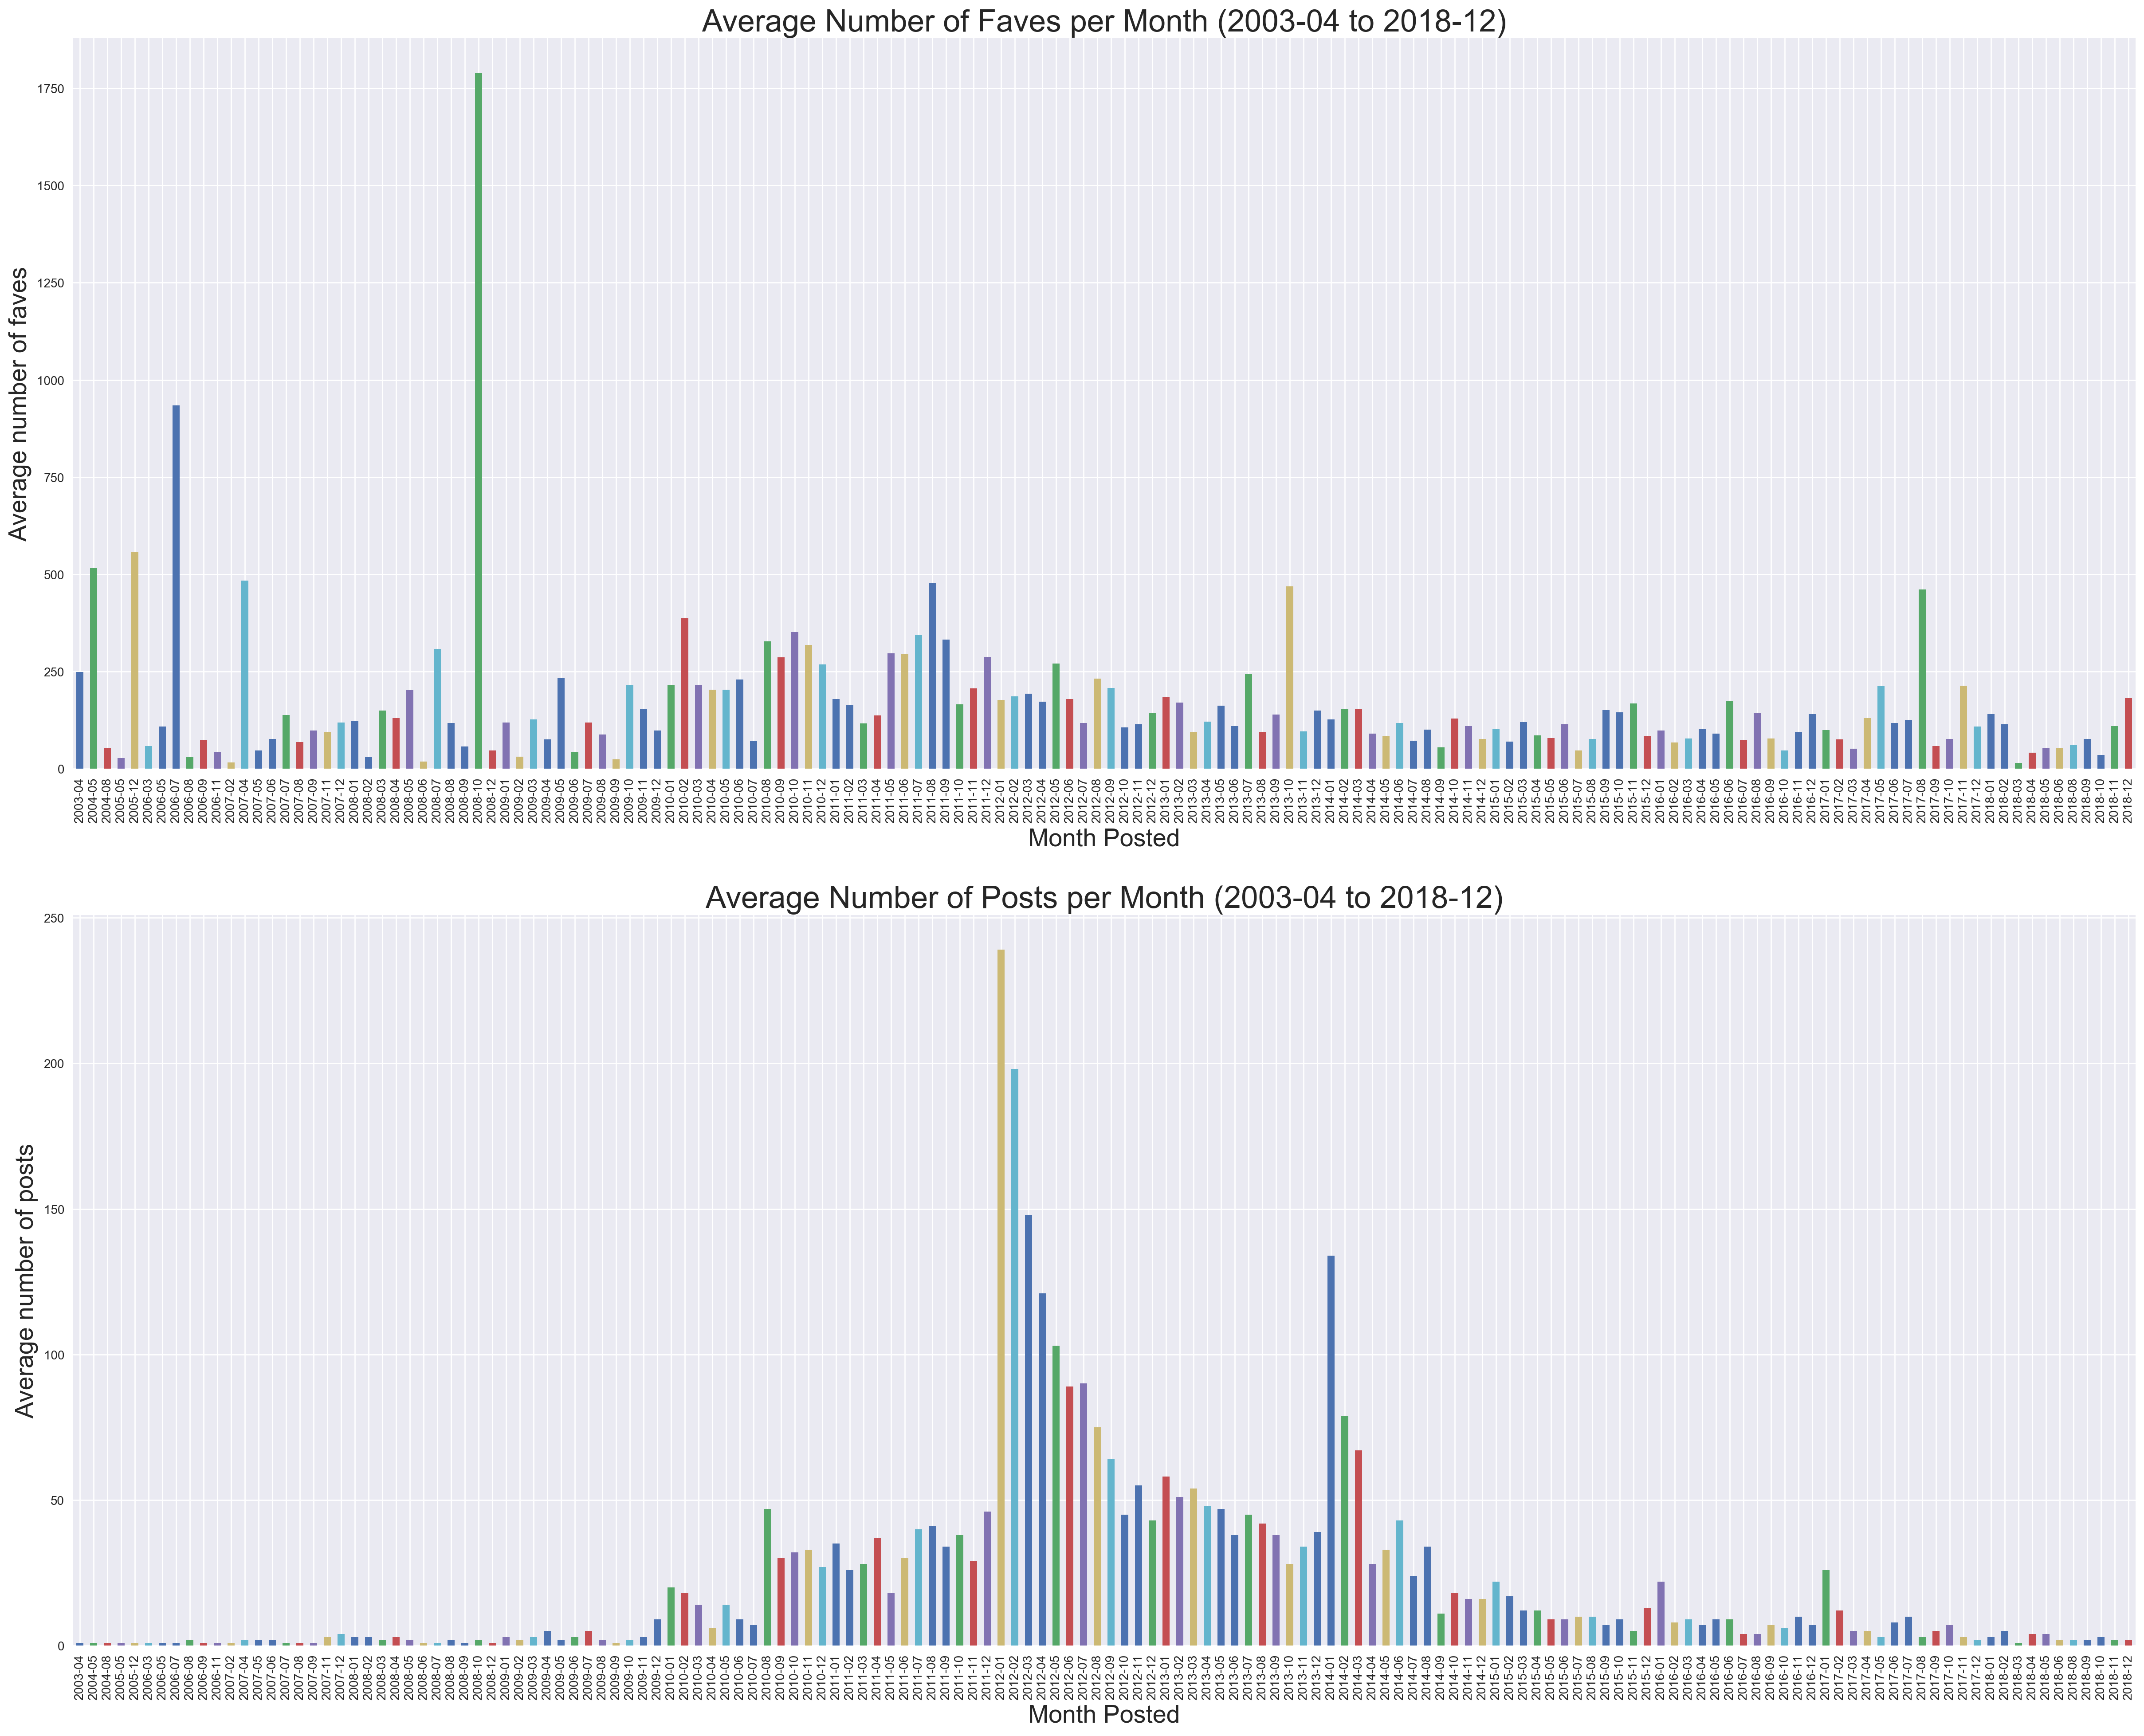

In [142]:
plt.figure(figsize=(30,24), dpi=200)

plt.subplot(211)
month_year_avg_faves['faves'].plot(kind='bar')
plt.title("Average Number of Faves per Month (2003-04 to 2018-12)", fontsize=25)
plt.xlabel("Month Posted", fontsize=20)
plt.xticks(fontsize=10, rotation=90)
plt.ylabel("Average number of faves", fontsize=20)

plt.subplot(212)
month_year_posts['faves'].plot(kind='bar')
plt.title("Average Number of Posts per Month (2003-04 to 2018-12)", fontsize=25)
plt.xlabel("Month Posted", fontsize=20)
plt.xticks(fontsize=10, rotation=90)
plt.ylabel("Average number of posts", fontsize=20)

,faves,artists,titles,image_paths,image_links
3181,118,halconrojo2006,Sherlock Holmes Museum London,[full/c03c98a2398bd2aa1450ff9a3eed774e9fe17495.jpg],https://www.deviantart.com/halconrojo2006/art/Sherlock-Holmes-Museum-London-101940689
3247,3460,Hideyoshi,Sherlock Holmes,[full/cf5fd090c1f8cb96bef89b500abb6974e66cb600.jpg],https://www.deviantart.com/hideyoshi/art/Sherlock-Holmes-99996840


3181    https://www.deviantart.com/halconrojo2006/art/Sherlock-Holmes-Museum-London-101940689
3247    https://www.deviantart.com/hideyoshi/art/Sherlock-Holmes-99996840                    
Name: image_links, dtype: object


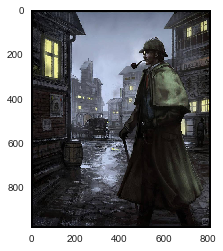

In [254]:
from datetime import datetime
import matplotlib.image as mpimg
from IPython.core.display import HTML

#find the outlier
outlier_date = datetime.strptime('2008-10','%Y-%m')
outlier_df = final_df[['faves','artists','titles','image_paths','image_links']].loc[np.where((
    final_df['year_posted'] == outlier_date.year) & (final_df['month_posted'] == outlier_date.month))]
display(HTML(outlier_df.to_html()))

print(outlier_df['image_links'])
img = mpimg.imread('DA-images/'+ 'full/cf5fd090c1f8cb96bef89b500abb6974e66cb600.jpg')
plt.imshow(img)
plt.grid(False)


<h2>Model-Building</h2>

In [ ]:
#linear models for social metric prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split

X = df[['time_period','no_of_posts']]
y = np.array(log_df['log-faves']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear_reg = LinearRegression().fit(X_train, y_train)
ridge_reg = RidgeCV().fit(X_train, y_train)
elastic_reg = ElasticNetCV().fit(X_train, y_train.ravel())


In [ ]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error

def predict_score(model, X_test, y_test):
    
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    expl_var = explained_variance_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    scores = [r2, expl_var, mae]
    
    return predictions, scores

lin_pred, lin_score = predict_score(linear_reg, X_test, y_test)
ridge_pred, ridge_score = predict_score(ridge_reg, X_test, y_test)
elastic_pred, elastic_score = predict_score(elastic_reg, X_test, y_test)


In [ ]:
scores_df = pd.DataFrame(
            {"Algorithm": ["Linear regression","Ridge regression","Elastic Net Regression"],
            "r2 score":[lin_score[0],ridge_score[0],elastic_score[0]],
            "Explained variance score":[lin_score[1],ridge_score[1],elastic_score[1]],
            "Mean Absolute Error (log)": [lin_score[2],ridge_score[2],elastic_score[2]],
            "Mean Absolute Error (normalized)":[np.exp(lin_score[2]),np.exp(ridge_score[2]),np.exp(elastic_score[2])]})
scores_df


<h2>CNN time</h2>

In [ ]:
from skimage.transform import resize
import matplotlib.image as mpimg

#create empty image lists
image_resized_lst = []
image_original_lst = []

#height and width of resized image
new_height = 250
new_width = 250


#image loading has to be done one-by-one to ensure that the images are loaded in the corresponding order to the
#data collected in the dataframe
for i in range(len(df)):
    my_dir = 'DA-images/'
    img_path = df['image_paths'][i][0]
    #load image
    img = mpimg.imread(my_dir + img_path)
    image_original_lst.append(img)
    #resize image
    img_resized = resize(img,(new_height,new_width),
                        mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
    image_resized_lst.append(img_resized)
    
original_arr = np.array(image_original_lst)
resized_arr = np.array(image_resized_lst)

In [ ]:
print(f"Original images array shape: {original_arr.shape}\nResized images array shape: {resized_arr.shape}")

In [ ]:
#peak at the resized images vs original images
fig, ax = plt.subplots(2, 6, figsize=(20, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(6):
    ax[0, i].imshow(original_arr[i])
    ax[1, i].imshow(resized_arr[i])
    ax[0, i].set_title(f"Faves: {df.faves[i]}")
    
ax[0, 0].set_ylabel('Images Original',size=15)
ax[1, 0].set_ylabel('Images Resized',size=15)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor

input_shape = (250,250,3)

def baseline_model():
    # create model
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(9, 9), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
# build regression estimator
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=20, verbose=1, validation_split=0.2)


In [ ]:
X = resized_arr
y = np.array(log_faves)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

In [ ]:
estimator.fit(X_train, y_train)

In [ ]:
y_train = np.exp(y_train)
prediction = estimator.predict(X_train)
prediction = np.exp(prediction)

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Real Faves: {y_train[i]}, \nPredicted Faves: {np.floor(prediction[i])}")
    plt.imshow(X_train[i])
    
print(f"Explained variance score: {explained_variance_score(y_train, prediction)}")
print(f"Mean absolute error: {mean_absolute_error(y_train, prediction)}")

In [ ]:


prediction = estimator.predict(X_test)
prediction = np.exp(prediction)
y_test = np.exp(y_test)

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Real Faves: {y_test[i]}, \nPredicted Faves: {np.floor(prediction[i])}")
    plt.imshow(X_test[i])
    
print(f"Explained variance score: {explained_variance_score(y_test, prediction)}")
print(f"Mean absolute error: {mean_absolute_error(y_test, prediction)}")

Ideas to improve the model:
- only select pics of a certain dimension? e.g. filter out pics that are too long or too tall.